# Chapter 3 - Multi-armed bandits: maximizing business metrics while experimenting

- If you have a good A/B testing setup, the quality of your system should ramp up over time
- As that happens, most "B" tests will be *worse* than what you currently have
- Pay a cost in evaluating worse options - the revenue you would have made had you not had to try that system out
- We can make the cost cheaper by reframing the problem: "While evaluating a change candidate in production, how can we maximize the number of times we measure the better of A and B?"
	- [[Multi-Armed Bandit Problem]]
	- If A is better than B, we want to measure it more
	- Problem: We don't know that until we measure it!
- We'll first modify A/B testing to use summary staistics of individual measurements to choose which candidate to run: [[Epsilon-Greedy Algorithm]]
- Next: Tweak it to evaluate mutliple versions at once
- Using more detailed statistics of the measurement - [[Thompson Sampling]]

## Epsilon-greedy: Account for the impact of evaluation on business metrics
- Most proposed changes are rejected by A/B testing
    - Most of our ideas are not that good
- Scenario: imagine you're an ML engineer responsible for placing banner ads on a website.
    - Each time a user appears on the website, the model is queried for the probability they'll click on each of the ads in the inventory
    - Say 1000 ads in the inventory
    - System serves the ad with the highest predicted probability of being clicked by the user
    - Component of the system resonsile for selecting which ad to serve is the *ad selector*
    - If the user clicks on an ad, you get \$1, the cost per click (CPC)
    - Given the financial incentives, want to measure the Click-Through Rate (CTR):
$$
\text{CTR} = \frac{\text{# clicks on ads}}{\text{# ads shown}}
$$
    - Total revenue per day (broader business concern) is CPC * CTR * number of visitors to the page
    - You can try to get the ad managers to increase the CPC
    - Your job - increase the CTR by building a better model of the probability a user clicks an ad
    - The *click model*
    
### A/B Testing as a baseline
- In [[Chapter 2]], we developed A/B Testing with the goal of taking the fewest possible measurements consistent with a [False positive]] rate < `0.05` and a [[False Negative]] rate < `0.2`.
- These probabilities are unitless -> we can apply them to lots of different systems - no need for domain knowledge
- when optimizing an engineered system, we want to increase a business metric:
    - Use an experiment to determine whether A or B is better
    - Use the better one from now on
- Taking the measurement means exposing users to a potentially worse system - it has real costs
- Modify step 1: during the experiment we most often measure whichever version has the highest CTR
- Let's create a simulation
    - Current version: A, w/ a CTR of `0.005` (slightly below the average of 0.006)
    - Other version: B, w/ a CTR of `0.007` (slightly above the average)

In [1]:
# libraries, &c
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def measure_click(ctr):
    return 1 if np.random.uniform(0, 1) < ctr else 0

def measure_a():
    return measure_click(0.005)

def measure_b():
    return measure_click(0.007)

Now we run an A/B test following the steps in chapter 2:
1. Run a pilot study to measure sd_1_delta, which we abbreviate as sd_1
1. Define a practical significance level, `prac_sig`
1. Caculate the number of individual measurements to take, `num_ind`

Let's take `prac_sig = 0.001`. Given the 0.005 is our current CTR, an improvement of 0.001 would mean 20% more revenue per day!

In [3]:
def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)])
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)])
        sd_1 = np.sqrt(clicked_pre_a.std() ** 2 + clicked_pre_b.std() ** 2)
        return sd_1
    
    sd_1 = pilot_study(1000)
    prac_sig = 0.001
    num_ind = (2.48 * sd_1 / prac_sig) ** 2
    return int(num_ind)

In [4]:
np.random.seed(17)
num_ind = design_ab_test()
num_ind

91561

This tells us that we need nearly 100 000 measurements, which might seem like a lot. However, since the CTR is so small (and so the revenue is low), in order to stay in business an ad company must serve much more than this.

Now for the actual test:

In [5]:
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []
    for _ in range(num_ind):
        # randomize between A and B
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            clicked_a.append(clicked)
        else:
            clicked = measure_b()
            clicked_b.append(clicked)
    return np.array(clicked_a), np.array(clicked_b)
    
# complete the experiment by computing the z scores:
def analyze_ab_test(clicked_a, clicked_b):
    mean_a = clicked_a.mean()
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()
    std_b = clicked_b.std()
    m = mean_b - mean_a
    se = np.sqrt((std_a ** 2 + std_b ** 2) / num_ind)
    z = m / se
    
    return z # determines whether we accept or reject version B

In [6]:
# Complete experiment:
np.random.seed(17)
num_ind = design_ab_test()
print(num_ind)
clicked_a, clicked_b = run_ab_test(num_ind)
z = analyze_ab_test(clicked_a, clicked_b)
num_ind, z

91561


(91561, 2.954555022088617)

The z-score is 2.95 > 1.64 -> we accept this and switch over to model B.

Before the test we ran A (CTR: 0.005). After, we run B: (CTR: 0.007). During the test, we randomized btween them, so have a combined CTR of (0.005 + 0.007) / 2 = 0.006.

That means we have *regret* (technical term). The A/B test produced a regret of

CTR of model B - CTR of the A / B test = 0.007 - 0.006 = 0.001

We missed out on 0.001 CTR by running the test.

Let's go deeper into how the CTR evolves while running the test:

In [7]:
def ab_test(num_ind):
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for _ in range(num_ind):
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        if num_a > 0 and num_b > 0:
            ctr_a.append(sum_a / num_a)
            ctr_b.append(sum_b / num_b)
            ctr_vs_n.append(sum_clicks / num_ads)
    return ctr_vs_n, ctr_a, ctr_b

Text(0, 0.5, 'CTR Through n')

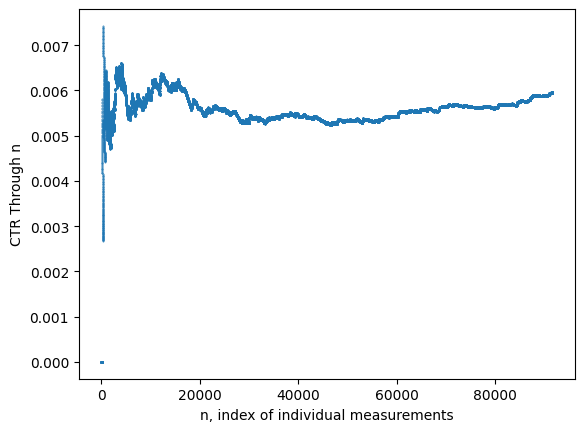

In [8]:
# Plot of one run
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
fig, ax = plt.subplots()
ax.scatter(range(len(ctr_vs_n)), ctr_vs_n, marker='.', s=0.5)
ax.set_xlabel("n, index of individual measurements")
ax.set_ylabel("CTR Through n")

Let's see the distribution over 100 runs:

In [9]:
all_runs = []
for _ in range(100):
    ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
    all_runs.append(ctr_vs_n)
means = []
upper_1_std = []
lower_1_std = []
for index in range(min(*[len(run) - 1 for run in all_runs])):
    measurements = np.array([run[index] for run in all_runs])
    mean = measurements.mean()
    std = measurements.std()
    means.append(mean)
    upper_1_std.append(mean + std)
    lower_1_std.append(mean - std)

Text(0, 0.5, 'Mean and 1 std around the CTR')

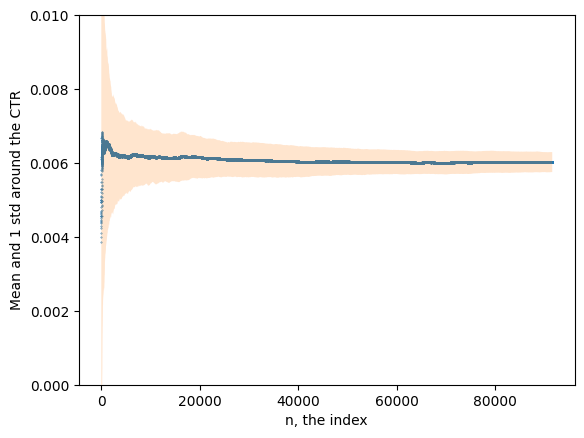

In [10]:
fig, ax = plt.subplots()
ax.scatter(range(len(means)), means, marker='.', s=0.5)
ax.fill_between(range(len(means)), lower_1_std, upper_1_std, alpha=0.2)
ax.set_ylim(0, 0.01)
ax.set_xlabel("n, the index")
ax.set_ylabel("Mean and 1 std around the CTR")

We can also plot the CTR for A vs B separately:

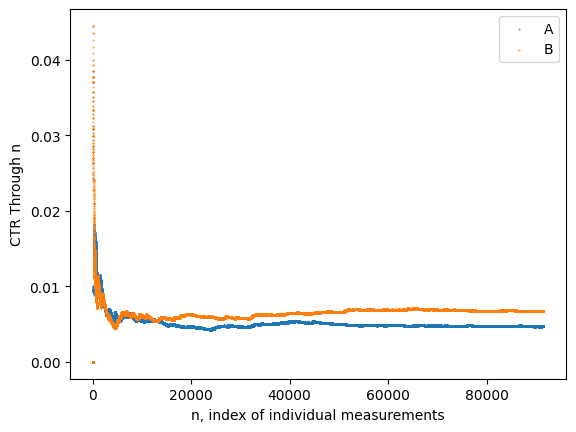

In [11]:
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
fig, ax = plt.subplots()
ax.scatter(range(len(ctr_a)), ctr_a, marker='.', s=0.5, label="A")
ax.scatter(range(len(ctr_b)), ctr_b, marker='.', s=0.5, label="B")
ax.set_xlabel("n, index of individual measurements")
ax.set_ylabel("CTR Through n")
ax.legend()

Looking at this graph, it would be tempting to stop around n=100 - when it is becoming clear that B is consistently outperforming A. This is well before our cutoff of 100 000! However, that runs the risk of false positives. One solution: the epsilon-greedy algorithm.

### The epsilon-greedy algorithm
Instead of choosing between A and B with equal probability, epsilon-greedy assigns a higher probability to whichever version has a higher CTR so far.

Works like this:

> With probability `1 - epsilon`, use the version with the higher CTR. otherwise, with probability epsilon, act like a regular A / B test and choose between them with equal probability

That means changing our model selection code from

```python
if np.random.uniform(0, 1) < 0.5:
    # Run A
else:
    # Run B
```

to 

```python
if np.random.uniform(0, 1) < 1 - epsilon:
    # run the one with higher CTR
else:
    if np.random.uniform(0, 1) < 0.5:
        # Run A
    else:
        # Run B
```

Note that if `epsilon=1`, the first branch never runs (behaves like a normal A / B test); if epsilon = 0, the first branch is always run. Thus, we can think of `epsilon` as controlling how greedy we are - 1 is no greed, 0 is always greedy!

Note also that `epsilon` is a paramter of the algorithm, not of the system. We refer to it as a *metaparameter*.

In [12]:
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    used_b = []
    for _ in range(num_ind):
        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
            elif ctr_a < ctr_b:
                select = "B"
        if select == 'Randomize':
            select = "A" if np.random.uniform(0, 1) < 0.5 else "B"
            
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
            used_b.append(False)
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
            used_b.append(True)
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        
    return ctr_vs_n, used_b

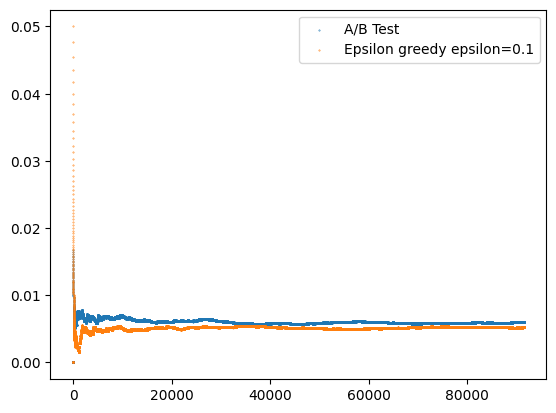

In [13]:
# comparing a run of epsilon_greedy with ab_test

epsilon = 0.1
epsilon_ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon=epsilon)
ab_test_ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)

fig, ax = plt.subplots()
min_n = min(len(epsilon_ctr_vs_n), len(ab_test_ctr_vs_n))
ax.scatter(range(min_n), ab_test_ctr_vs_n[:min_n], label="A/B Test", s=0.5, marker='.')
ax.scatter(range(min_n), epsilon_ctr_vs_n[:min_n], label=f"Epsilon greedy {epsilon=}", s=0.5, marker='.')
ax.legend()

So epsilon-greedy is outperforming the regular AB test - there's less regret!

Raw numbers:

In [14]:
print(epsilon_ctr_vs_n[-1], ab_test_ctr_vs_n[-1])
print(epsilon_ctr_vs_n[-1] - ab_test_ctr_vs_n[-1])

0.005242406701543234 0.005974159303633643
-0.0007317526020904092


So that's a pretty significant improvement! In fact, it's only slightly worse than the optimal - switching to B right at the beginning! (The actual number is higher, but that's just the last one)

In [15]:
NUM_RUNS = 100

all_ab_runs = []
for _ in range(NUM_RUNS):
    ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
    all_ab_runs.append(ctr_vs_n)
ab_means = []
ab_upper_1_std = []
ab_lower_1_std = []
max_length = min(*[len(run) for run in all_ab_runs])
for index in range(max_length):
    measurements = np.array([run[index] for run in all_ab_runs])
    mean = measurements.mean()
    std = measurements.std()
    ab_means.append(mean)
    ab_upper_1_std.append(mean + std)
    ab_lower_1_std.append(mean - std)
    
epsilon = 0.1
all_epsilon_runs = []
for _ in range(NUM_RUNS):
    ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon)
    all_epsilon_runs.append(ctr_vs_n)
epsilon_means = []
epsilon_upper_1_std = []
epsilon_lower_1_std = []
max_length = min(*[len(run) for run in all_epsilon_runs])
for index in range(max_length):
    measurements = np.array([run[index] for run in all_epsilon_runs])
    mean = measurements.mean()
    std = measurements.std()
    epsilon_means.append(mean)
    epsilon_upper_1_std.append(mean + std)
    epsilon_lower_1_std.append(mean - std)

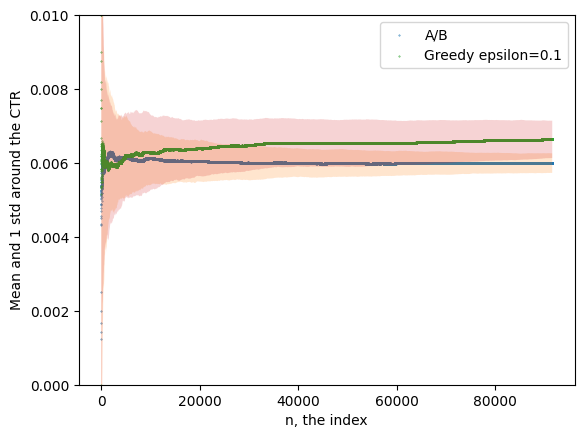

In [16]:
fig, ax = plt.subplots()

ax.scatter(range(len(ab_means)), ab_means, marker='.', s=0.5, label="A/B")
ax.fill_between(range(len(ab_means)), ab_lower_1_std, ab_upper_1_std, alpha=0.2)

ax.scatter(range(len(epsilon_means)), epsilon_means, marker='.', s=0.5, label=f"Greedy {epsilon=}")
ax.fill_between(range(len(epsilon_means)), epsilon_lower_1_std, epsilon_upper_1_std, alpha=0.2)

ax.set_ylim(0, 0.01)
ax.set_xlabel("n, the index")
ax.set_ylabel("Mean and 1 std around the CTR")
ax.legend()

We can also compare the number of times that B was chosen by epsilon-greedy. Recall that for a normal AB test, it would be chosen 50% of the time.

In [17]:
ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon)
percentage_b = []
total_b = 0
for index, was_b_used in enumerate(used_b):
    total_b += 1 if was_b_used else 0
    percentage_b.append(total_b / (index + 1))

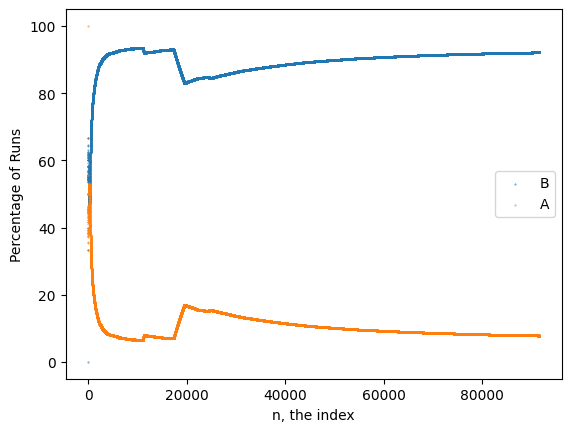

In [18]:
fig, ax = plt.subplots()
ax.scatter(range(len(percentage_b)), [percentage * 100 for percentage in percentage_b], marker='.', s=0.5, label="B")
ax.scatter(range(len(percentage_b)), [100 - percentage * 100 for percentage in percentage_b], marker='.', s=0.5, label="A")
ax.set_xlabel("n, the index")
ax.set_ylabel("Percentage of Runs")
ax.legend()

So you can see that pretty quickly, the percentage of time we're choosing B is converging on 1 - epsilon = 0.9.

Explorative measurements - the 10% that we always take to make sure we're not being fooled
Exploitative measurements - the 90% we're taking for the one we're pretty sure is better

The epsilon metaparameter controls how often we explore vs. exploit. With epsilon=0.1, we explore 10% of the time and exploit 90%. We say that epsilon-greedy "balances exploration with exploitation".

### Deciding When to Stop

In our formulation so far, there is no prescription to stop. Before, we chose `num_ind`, the number we would need for a regular A/B test. In reality, however, that is not quite correct - since we're smampling different numbers of A and B the number we calculated for the AB test doesn't apply.

The goal with epsilon-greedy is to maximize the business metric, the CTR. Slight modification to get it to stop: at each step, set
$$
\text{epsilon} = 2 \times c \times \frac{\left( \frac{\text{BM}_{\text{MAX}}}{\text{PS}} \right)^2}{n}
$$
where
- $\text{BM}_{\text{MAX}}$ is the largest plausible value of the business metric - say, 0.01. It's there to scale the practical significance so it becomes unitless
- $\text{PS}$ is the practical significance `prac_sig`
- $c$ controls how much time is spent in pure explortion

Note that epsilon is proportional to 1/n - it will decay towards 0. When epsilon is 1 or larger, it will *only* explore. When it falls below 1, it starts exploiting. We'll use $c=5$, but this should be carefully considered. Setting $c$ too high -> too much exploration; setting it too low -> starts exploiting too quickly and so may produce false positives / false negatives.

Note also that there is no dependence on the actual measurements - epsilon will decay on a fixed schedule.

We stop when epsilon gets below some fairly arbitrary threshold - say 0.02 or 0.005. The sensitivity to the exact threshold is low.

Basically, when the algorithm stops we check which one has the higher CTR and use that one.

In [19]:
def epsilon_greedy_decay():
    bm_max = 0.01
    prac_sig = 0.001
    c = 5
    
    epsilon_0 = 2 * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01
    
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    epsilons = []
    
    n = 0
    selected = None
    while True:
        epsilon = min(1, epsilon_0 / (n + 1))
        epsilons.append(epsilon)
        if epsilon < epsilon_stop:
            break
            
        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
                selected = "A"
            elif ctr_a < ctr_b:
                select = "B"
                selected = "B"
        if select == 'Randomize':
            select = "A" if np.random.uniform(0, 1) < 0.5 else "B"
            
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1
        
    if selected == "B":
        accept_reject = "Accept"
    else:
        accept_reject = "Reject"
        
    return ctr_vs_n, epsilons, accept_reject

In [20]:
ctr_vs_n, epsilons, accept_reject = epsilon_greedy_decay()

Text(0, 0.5, 'epsilon')

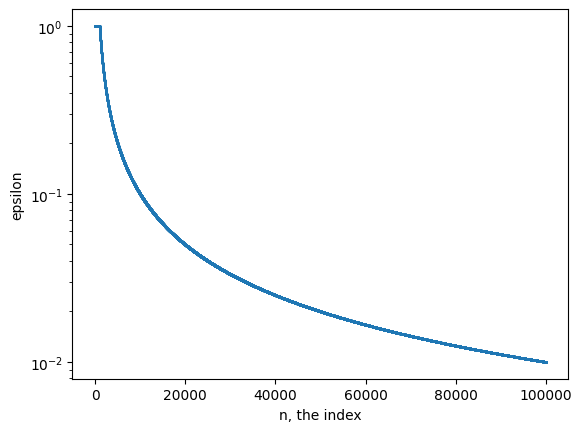

In [21]:
fig, ax = plt.subplots()
ax.scatter(range(len(epsilons)), epsilons, marker='.', s=0.5)
ax.set_yscale('log')
ax.set_xlabel("n, the index")
ax.set_ylabel("epsilon")

Note that this stopped after 100 000, below the recommended one of about 200 000. In order to make a fair comparison, we should run the `epsilon_greedy_decay` one until it stops, then continue running the recommended option until it reaches the number of tests that `ab_test` gets.

If you do this, you find that `epsilon_greedy_decay` outperforms both `epsilon_greedy` and `ab_test`. You can prove that `epsilon_greedy_decay` outperforms those other two under a wide variety of circumstances.

Several papers have shown the optimality of `epsilon_greedy_decay` - the catch is that you need to tune the `c` parameter.

#### False Positives, False Negatives

Recall that A/B test design specifies a maximum false-positive rate of 5% and a maximum false-negative rate of 20%. This asymmetry says that it is more acceptable to stick with A when B is better (false negative) than to switch to B when it is worse (false positive).

In our tests, the `epsilon_greedy_decay` has false positive and false negative rates of 2%, although this depends strongly on the choce of tuning metaparamter `c`. 

In summary, an epsilon-greedy epriment can be carried out by
- *Design* - Determine $PS$ and $BM_{MAX}$ from business considerations and set a value for c (e.g. $c=5$)
- *Measure* - Select between versions A and B using epsilon-greedy's biased randomization, which explores with a rate
$$
epsilon = 2 \times c \times \frac{\left( \frac{BM_{MAX}}{PS} \right)^2}{n}
$$
Stop when epsilon falls below 0.01
- *Analyze* - Accept B if it has a higher realized business metric than A, or else reject it

## Evaluating Multiple System Changes Simultaneously

In practice, you might need to choose between more than two different systems. For instance, you might have several different click models which all performed about the same offline, or you might have the same system but with different metaparameter values (e.g. `c` for `epsilon_greedy_decay`)

We might want to test between versions A, B, C, D, ...

We call each different option *arms* (after the [[Multi-Armed Bandit]]). The modification to epsilon-greedy is as follows:
- With probability epsilon, select between A, B, C, D, ... randomly; otherwise, choose whichever one has the highest realized CTR

Now the new epsilon is
$$
epsilon = K \times c \times \frac{\left( \frac{BM_{MAX}}{PS} \right)^2}{n}
$$
where $K$ is the number of arms; when there were two (A & B), we used 2. Notice that the stopping $n$ is linear in $K$, the number of arms. We set the stopping condition as epsilon = 0.01, so
$$
n_{\text{stop}} = K \times c \times \frac{\left(\frac{\text{BM}_{\text{MAX}}}{\text{PS}} \right)^2}{0.01}
$$

For our scenario with $BM_{MAX} = 0.01$, $PS = 0.001$, $c=5$, and $K=4$, we get $n_{\text{stop}} = 200 000$

In [22]:
def epsilon_greedy_decay_multi():
    bm_max = 0.01
    prac_sig = 0.001
    K = 4 # number of arms
    c = 5
    
    epsilon_0 = K * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01
    
    sum_clicks = 0
    num_ads = 0
    sum_arm = [0] * K
    num_arm = [0] * K
    ctr_vs_n = []
    
    n = 0
    arms_selected = []
    while True:
        epsilon = min(1, epsilon_0 / (n + 1))
        if epsilon < epsilon_stop:
            break
            
        i_selected = None
        if np.random.uniform(0, 1) < 1 - epsilon:
            max_ctr = None
            for i in range(K):
                if num_arm[i] > 0:
                    ctr_arm = sum_arm[i] / num_arm[i]
                else:
                    ctr_arm = 0
                # break ties by randomizing
                ctr_arm += 1e-9 * np.random.normal()
                if max_ctr == None or ctr_arm > max_ctr:
                    max_ctr = ctr_arm
                    i_selected = i
        else:
            i_selected = np.random.randint(K)
        
        arms_selected.append(i_selected)
        clicked = measure_arm(i_selected)
        sum_arm[i_selected] += clicked
        num_arm[i_selected] += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1
        
    return ctr_vs_n, arms_selected

def measure_arm(i_arm):
    return measure_click(ctr=0.005 + i_arm * 0.002) # for convenience; there doesn't need to be a relationship between i and the ctr

In [23]:
ctr_vs_n, arms_selected = epsilon_greedy_decay_multi()

Text(0, 0.5, 'CTR')

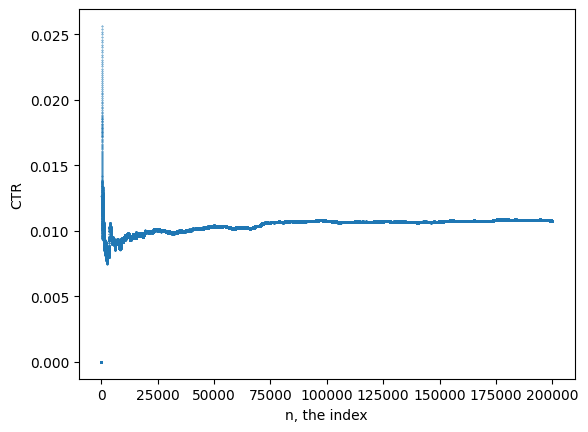

In [24]:
# plot ctr vs. n
fig, ax = plt.subplots()
ax.scatter(range(len(ctr_vs_n)), ctr_vs_n, s=0.5, marker='.')
ax.set_xlabel(f'n, the index')
ax.set_ylabel(f'CTR')

In [25]:
# percentage of arms selected at each stage
K = 4
K_percentages_vs_n = [[] for _ in range(K)]
K_nums = [0] * K
for index, i_selected in enumerate(arms_selected):
    K_nums[i_selected] += 1
    for K_index, K_percentage in enumerate(K_percentages_vs_n):
        K_percentage.append(K_nums[K_index] / (index + 1))

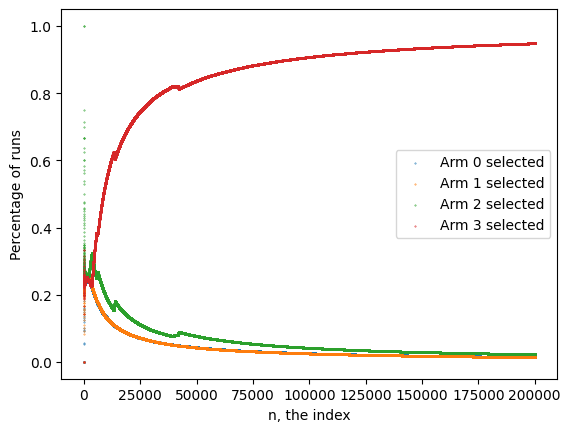

In [26]:
fig, ax = plt.subplots()
for K_index, K_percentages in enumerate(K_percentages_vs_n):
    ax.scatter(range(len(K_percentages)), K_percentages, s=0.5, marker='.', label=f"Arm {K_index} selected")
ax.set_xlabel('n, the index')
ax.set_ylabel('Percentage of runs')
ax.legend()


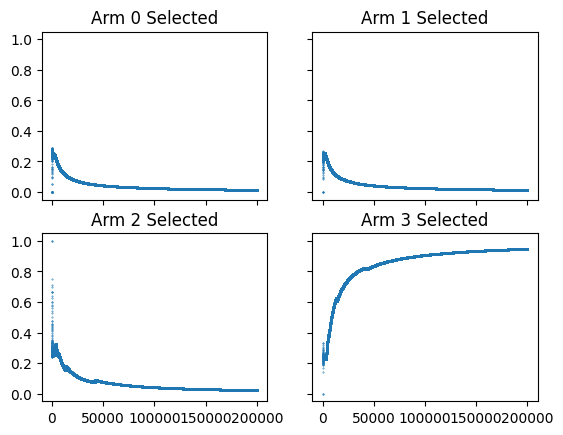

In [27]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for ax_row_index, ax_row in enumerate(axes):
    for ax_col_index, ax in enumerate(ax_row):
        K_index = ax_row_index * len(axes) + ax_col_index
        K_percentages = K_percentages_vs_n[K_index]
        ax.scatter(range(len(K_percentages)), K_percentages, marker='.', s=0.5)
        ax.set_title(f"Arm {K_index} Selected")

So, with this one easy change, we can extend the epsilon-greedy algorithm to handle any countable number of scenarios.

## Thompson sampling - a more efficient MAB algorithm

We can do better! [[Thompson Sampling]] produces a higher CTR, faster, and doesn't require tuning with metaparameters like `c`.

[[Thompson Sampling]] calculates the probability that each arm is the best, and then randomly chooses between them in proportion to that probability:

$$
p_{\text{measure}}(\text{arm}) = p_{\text{best}}(\text{arm})
$$

This rule is a *randomized probability matching* rule.

The choice of arms is random (exploration), but better-seeming arms get run more often (exploitation). As more information is gathered, we become more certain about which one is the best and so it gets chosen more and more regularly. Thompson sampling stops when $p_{\text{best}}(\text{arm}) > p_\text{stop} = 0.95$ (a metaparameter).

#### A note on metaparameters

The metaparameter `c` from section 3.1.2. affects both the initial rate of exploration and the stopping time. The value of `c` that is optimal for that system almost srely isn't for a different one, and must be determined through trial and error.

That's a very different situation than regular A/B testing, where the same metaparameters (probabilities of false positives or false negatives) were the same for basically every A/B test.

The metaparameter $p_\text{stop}$ is [[Thompson Sampling]] is more like the A/B test metaparamter - we can use the same value for basically whatever test we're running. Also, it has a very clear interpretation in case we need to change it.

### Estimate the probability that an arm is best
We measure the quality of a click model by the CTR it produces. We will use [[Bootstrap Sampling]] to compute $p_\text{best}(\text{arm})$.

$$
\text{CTR} = \frac{\text{# clicks}}{\text{# ads}}
$$
or

$$
\text{CTR} = \text{mean}(I_\text{clicked})
$$

where $I_{\text{clicked}}$ is a vector of length equal to the number of ads shown and where the $i^\text{th}$ element is 1 if the ad was clicked and 0 otherwise.

CTR is an aggregate measure. We quantify the uncertainty as

$$
SE = \frac{stddev(CTR)}{num_ind}
$$

In [28]:
I_clicked = np.array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0])
CTR = I_clicked.mean() # 4 / 10 = 0.4
SE = I_clicked.std() / np.sqrt(len(I_clicked))
print(f"{CTR=}; {SE=}")

CTR=0.4; SE=0.15491933384829668


Recall that the SE is an estimate. We can't compute it directly because we only take one value of the aggregate measure per experiment. If we ran many experiments we could just measure it directly, but we don't want to do that.

However, there is a way (kind of) of using our existing data to pretend we have lots of experiments!

#### Bootstrap sampling

In the previous section, we collected 1 set of 10 measurements, `I_clicked`, from which we computed the mean and the standard error. [[Bootstrap Sampling]] generates synthetic measurement sets from a single, real mesurement set - it makes  fake `I_clicked` vector from a real one.

As an introduction, let's generate some synthetic measurement sets and compute the aggregate measurement, CTR, for each one. Here's how we do it:

1. Choose a value at random from the 10 `I_clicked` values
2. Choose a value at random from the 10 `I_clicked` values
3. Choose a value at random from the 10 `I_clicked` values
...
10. Choose a value at random from the 10 `I_clicked` values

Note that at each step we sample *with replacement*

In [29]:
def bootstrap_sample(data):
    n = len(data)
    return data[np.random.randint(n, size=(n,))] # returns n random elements of data

# let's see what this looks like
np.random.seed(17)
for _ in range(3):
    print(bootstrap_sample(I_clicked))

[0 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0]


(array([  3.,  39., 121., 215., 261., 207., 107.,  32.,  13.,   2.]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <BarContainer object of 10 artists>)

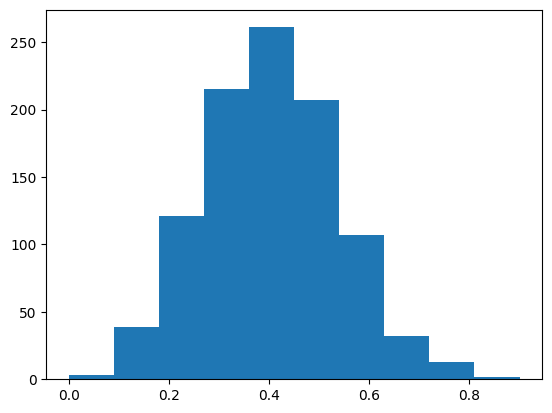

In [30]:
# histogram of CTR for the bootstrapped samples
data = np.array([bootstrap_sample(I_clicked).mean() for _ in range(1000)])
fig, ax = plt.subplots()
ax.hist(data)

The samples that we generate have the same mean and std as the original `I_clicked`

In [31]:
data.mean(), data.std()

(0.3993, 0.1509619488480458)

#### Working with few individual measurements

Mean of a large number of individual measurements follows a normal distribution (good approximation). THe more measurements we include in the mean, the better the approximation.

You might be tempted to just use a Gaussian approximation then and avoid all of this bootstrap nonsense. However, one of the goals of the test is to take *as few measurements as possible*, in which case our normality assumption might not work. As such,using a bootstrap allows us to forget about the step of modelling a (possibly not normal) distribution.

#### Probability of being the best arm

Let's say that we're comparing two click models (arms) and for each arm we have 10 000 measurements:

In [32]:
I_clicked_1 = np.array([measure_click(ctr=0.005) for _ in range(10_000)])
I_clicked_2 = np.array([measure_click(ctr=0.007) for _ in range(10_000)])

In [33]:
NUM_SAMPLES = 10_000
data1 = np.array([bootstrap_sample(I_clicked_1).mean() for _ in range(NUM_SAMPLES)])
data2 = np.array([bootstrap_sample(I_clicked_2).mean() for _ in range(NUM_SAMPLES)])

(array([  17.,  142.,  812., 2169., 3020., 2338., 1130.,  304.,   62.,
           6.]),
 array([0.0048, 0.0055, 0.0062, 0.0069, 0.0076, 0.0083, 0.009 , 0.0097,
        0.0104, 0.0111, 0.0118]),
 <BarContainer object of 10 artists>)

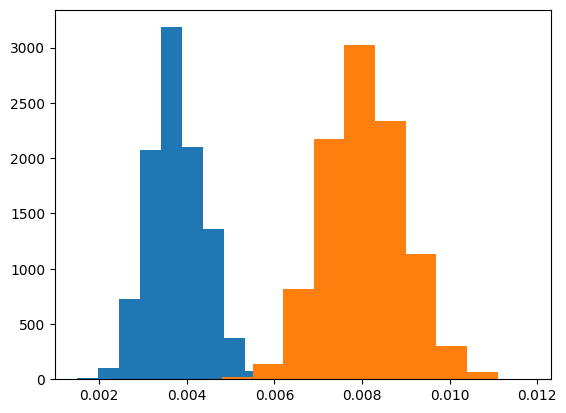

In [34]:
fig, ax = plt.subplots()
ax.hist(data1, label="Arm 1")
ax.hist(data2, label="Arm 2")

From this, it's not 100% clear that model 2 is better - there's some uncertainty. To simulate this, we can say that the probability that the arm is the best is roughly the number of times that it beats the other arms when you take a sample (say, 100 times).

In [35]:
def estimate_pbest(I_clicked_1, I_clicked_2):
    counts = [0, 0]
    
    num_samples = 100
    for _ in range(num_samples):
        ctr_1 = bootstrap_samples(I_clicked_1).mean()
        ctr_2 = bootstrap_samples(I_clicked_2).mean()
        if ctr_1 > ctr_2:
            counts[0] += 1
        elif ctr_1 < ctr_2:
            counts[1] += 1
        else: # we ignore cases where they're equal
            pass
    p_best = np.array(counts) / num_samples
    return p_best

So this returns an array `[pbest(arm1), pbest(arm2)]` - the probability that each arms is the best, estimated from 100 bootstrap samples. Note that it's not quite the actual probabilities because we skip some measurements where the CTR was equal!

We can easily extend this to an arbitrary number of arms:

In [36]:
def estimate_pbest(I_clickeds):
    counts = [0] * len(I_clickeds)
    
    num_samples = 100
    for _ in range(num_samples):
        ctrs = np.array([bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds])
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1: # only count the cases where there are no ties
            counts[i[0]] += 1
    p_best = np.array(counts) / num_samples
    return p_best

In [37]:
# running it on some sample data
np.random.seed(17)
I_clickeds = [None] * 4
NUM_SAMPLES = 10_000
I_clickeds[0] = np.array([measure_click(ctr=0.003) for _ in range(NUM_SAMPLES)])
I_clickeds[1] = np.array([measure_click(ctr=0.005) for _ in range(NUM_SAMPLES)])
I_clickeds[2] = np.array([measure_click(ctr=0.007) for _ in range(NUM_SAMPLES)])
I_clickeds[3] = np.array([measure_click(ctr=0.009) for _ in range(NUM_SAMPLES)])
estimate_pbest(I_clickeds)

array([0.  , 0.  , 0.04, 0.94])

### Randomized Probability Matching

Imagine that we're testing two different models in production: A and B. We find that $p_\text{best}(A) = 0.75$, $p_\text{best}(B) = 0.25$.
- Normal A / B test: choose A with probability 0.5
- Epsilon-greedy: choose A with probability 1 - epsilon (0.9)
- Thompson sampling: choose A with probability 0.75

This approach is called *randomized probability matching*

In principle, we already know enough to do this. The problem is that it can be too slow for effective use. However, there's a trick to speed it up:
1. Create one bootstrap sample for each arm
1. Estimate the CTR from each bootstrap sample
1. Measure the arm with the highest estimated CTR

The trick lies in the probability that an arm's bootstrap-estimated CTR is higher than the other arms' is exactly $p_\text{best}(\text{arm})$. Note that we're not actually estimating $p_\text{best}(\text{arm})$, we're just selecting an arm to measure in a way that obeys

$$
p_\text{measure}(\text{arm}) = p_\text{best}(\text{arm})
$$

---
Note: what we're doing in this chapter is a variant of [[Thompson Sampling]] called *bootstrap Thompson Sampling*. There are other ways to do it as well - see this [Stanford tutorial](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) for more information.

---


In [38]:
def rpm_select_arm(I_clickeds):
    ctrs = np.array([bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds])
    i = np.where(ctrs == ctrs.max())[0]
    if len(i) != 1:
        return np.random.randint(len(I_clickeds)) # why not return a random one of the ties?
    return i[0]

However, even this is not great. Each call to `bootstrap_sample` accesses the entire collected data set. Since the function call happens on every arm-selection process, and the data grows linearly with the number of decisions, the running time of the algorithm will scale as *number of calls to `rpm_select_arm`* $\times$ *size of data set* = $O(T^2)$, where $T$ is the number of randomization decisions (proportional to time).

Basically: the longer we run the experiment, the longer each decision will take until it is too slow for production use.

#### Online Bootstrap
One solution to to construct an incremental (e.g. *online*) bootstrap sampler that doesn't need to access the entire dataset, but rather, just the latest result.
- With $p=0.5$, add each new measurement to a running sum
- When you need the bootstrap mean, just divide by the number added
- Drawback: you only have access to a single bootstrap sample. To fix that, track $B$ of these means. Then the running time is $O(T^2) \to O(BT) = O(T)$, since $B$ is constant.

In [39]:
class OnlineBootstrap:
    """ Online bootstrap for a single arm """
    def __init__(self, num_bs_means): # track num_bs_means for a single arm
        self._sums = np.zeros(shape=(num_bs_means,)) # track sum and number of samples for each CTR
        self._n = np.zeros(shape=(num_bs_means,))
        self._count = 0 # number of samples we've taken
        
    def append(self, clicked):
        i = np.where(np.random.randint(2, size=(len(self._n))) == 0)[0]
        self._sums[i] += 1
        self._n[i] += 1
        self._count += 1
        
    def CTR_estimate(self):
        i = np.random.randint(len(self._n)) # select one of the CTRs at random
        if self._n[i] == 0:
            return np.inf # if no data has been collected, force it to be measured
        return self._sums[i] / self._n[i] # estimate the CTR from one of the tracked bootstrap means
    
    def count(self):
        return self._count
    
def estimate_pbest_ob(obs):
    counts = [0] * len(obs)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = np.array([ob.CTR_estimate() for ob in obs])
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:
            counts[i[0]] += 1
    return np.array(counts) / num_samples

Randomized probability matching falls between the extremes of A / B testing (each one equally) and epsilon-greedy (best w/ probability 1-epsilon). Online bootstrapping is the more computationally efficient version where the length of time to make a decision doesn't grow with time.

### The Complete Algorithm

We now have all of the components:
- `estimate_pbest_ob()` - calculate $p_\text{best}(\text{arm})$ efficiently
- `rpm_select_arm_ob` - randomized probability matching for arm selection
- A stopping rule, which also uses $p_\text{best}$

Two more loose ends:
- How many bootstrap means to collect? The author finds he needs at least 100 in practice. There a tradeoff - the more you have, the more exact the estimate but the longer it takes.
- Need to ensure that our estimates of CTR are precise enough to detect differences at the level of practice significance.

---
#### Discretization Error

CTR is estimatd with `CTR = I_clicked.mean()`, where `I_clicked` is either 0 or 1.

Consider two measurements:

$$
CTR_A = \frac{0 + 1 + 1 + 0 + \dots}{n}
$$
$$
CTR_B = \frac{0 + 1 + 1 + 0 + \dots}{n}
$$

The least (kind of) that these two CTRs could differ by is 1 click. Then $\left|CTR_A - CTR_B\right| = \frac{1}{n}$. We want enough values so that the smallest difference is no larger than PS (to ensure that we can detect a difference that large:

$$
\left|CTR_A - CTR_B\right| = \frac{1}{n} \leq PS \to n = \text{smallest difference in sums} / PS = 1 / PS
$$

The source of imprecision - due to the discrete nature of what we're measuring - is separate from the natural variability (measured with SE). Both sources of imprecision should be accounted for.

---

In [45]:
# putting it all together:
def thompson_sampling():
    k = 4
    num_bs_means = 100
    p_stop = 0.95 # stop when the probability of an arm being the best is 95%
    smallest_sum_difference = 1
    prac_sig = 0.001
    
    min_samples_per_arm = smallest_sum_difference / prac_sig # take enough samples to overcome the imprecision due to discretization
    
    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]
    sum_clicks = 0
    num_ads = 0
    ctr_vs_n = []
    
    n = 0
    while True:
        num_samples_per_arm = [ob.count() for ob in obs]
        i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0]
        if len(i_too_few) > 0: # be sure that all arms have the minimum number of samples using RPM
            i_selected = np.random.choice(i_too_few)
        else:
            i_selected = rpm_select_arm_ob(obs)
        i_clicked = measure_arm(i_selectd)
        obs[i_selected].append(i_clicked)
        sum_clicks += i_clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)
        
        n += 1
        if len(i_too_few) == 0 and n % 100 == 0: # because estimating b_pest is so slow, we only run it every 100 iterations
            p_bests = estimate_pbest_ob(obs)
            i_best_arm = np.where(p_bests == p_bests.max())[0]
            if len(i_best_arm) == 1 and p_bests.meax() >= p_stop:
                break
                
    return ctr_vs_n, i_best_arm

This completes much more quickly than epsilon-greedy, requiring only about 20 000 runs (vs 200 000 for epsilon-greedy). 

Thompson sampling:
- *design*: choose a stopping threshold for $p_\text{best}(\text{arm})$ (e.g. 95%)
- *measure*: Use randomized proability matching to choose an arm at each step. Online bootstrap makes this more efficient.
- *analyze*: Choose the arm that has the highest $p_\text{best}(\text{arm})$.